In [1]:
# Ensemble Learning and Random Forests

In [2]:
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
# In this chapter we will discuss the most popular Ensemble methods, 
# including bagging, boosting, and stacking. We will also explore Random Forests.

In [4]:
# Voting Classifiers

In [6]:
# Suppose you have trained a few classifiers, 
# each one achieving about 80% accuracy. You may have a Logistic Regression classifier, 
# an SVM classifier, a Random Forest classifier, 
# a K-Nearest Neighbors classifier, and perhaps a few more.

# A very simple way to create an even better classifier is to 
# aggregate the predictions of each classifier and 
# predict the class that gets the most votes. 
# This majority-vote classifier is called a hard voting classifier

In [7]:
# Somewhat surprisingly, this voting classifier often 
# achieves a higher accuracy than the best classifier in the ensemble. 
# In fact, even if each classifier is a weak learner 
# (meaning it does only slightly better than random guessing), 
# the ensemble can still be a strong learner (achieving high accuracy), 
# provided there are a sufficient number of weak learners and 
# they are sufficiently diverse.

In [9]:
# Suppose you have a slightly biased coin that has a 51% chance of coming up heads 
# and 49% chance of coming up tails.

# If you toss it 1,000 times, you will generally get more or less 510 heads and 490 tails, 
# and hence a majority of heads. If you do the math, 
# you will find that the probability of obtaining a majority of heads 
# after 1,000 tosses is close to 75%. 

# The more you toss the coin, 
# the higher the probability (e.g., with 10,000 tosses, the probability climbs over 97%).
# This is due to the law of large numbers: as you keep tossing the coin, 
# the ratio of heads gets closer and closer to the probability of heads (51%).

In [10]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

Saving figure law_of_large_numbers_plot


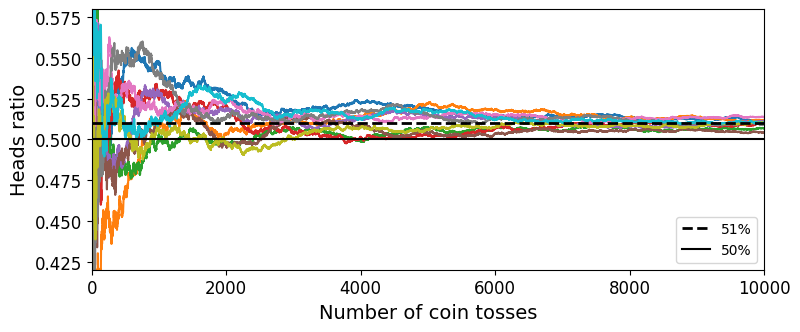

In [11]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

In [12]:
# Ensemble methods work best when the predictors are as 
# independent from one another as possible. 
# One way to get diverse classifiers is to train them using very different algorithms.
# This increases the chance that they will make very different types of errors, 
# improving the ensemble’s accuracy.

In [14]:
# The following code creates and trains a voting classifier in Scikit-Learn, 
# omposed of three diverse classifiers (the training set is the moons dataset, introduced in Chapter 5):

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

,estimators,"[('lr', ...), ('rf', ...), ...]"
,voting,'hard'
,weights,None
,n_jobs,None
,flatten_transform,True
,verbose,False
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True


In [18]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.888
SVC 0.896
VotingClassifier 0.888


In [19]:
# If all classifiers are able to estimate class probabilities 
# (i.e., they all have a pre dict_proba() method), 
# then you can tell Scikit-Learn to predict the class with the
# highest class probability, averaged over all the individual classifiers.

# This is called soft voting. It often achieves higher performance than 
# hard voting because it gives more weight to highly confident votes. 
# All you need to do is replace voting="hard" with voting="soft" 
# and ensure that all classifiers can estimate class probabilities.

In [20]:
# Bagging and Pasting

In [21]:
# One way to get a diverse set of classifiers is 
# to use very different training algorithms, as just discussed. 
# Another approach is to use the same training algorithm for every
# predictor and train them on different random subsets of the training set.

# Whn sampling is performed with replacement, 
# this method is called bagging (short for bootstrap aggregating). 
# When sampling is performed without replacement, it is called pasting.

In [23]:
# In other words, both bagging and pasting allow training instances 
# to be sampled several times across multiple predictors, 
# but only bagging allows training instances to be 
# sampled several times for the same predictor.

# Once all predictors are trained, the ensemble can make a prediction for a new
# instance by simply aggregating the predictions of all predictors. 
# The aggregation function is typically the statistical mode 
# (i.e., the most frequent prediction, just like a hard voting classifier) 
# for classification, or the average for regression.

In [24]:
# Bagging and Pasting in Scikit-Learn

In [25]:
# Scikit-Learn offers a simple API for both bagging and pasting with
# the BaggingClassifier class (or BaggingRegressor for regression).

# The following code trains an ensemble of 500 Decision Tree classifiers: 
# each is trained on 100 training instances randomly sampled from 
# the training set with replacement (this is an example of bagging,
# but if you want to use pasting instead, just set bootstrap=False).

In [27]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [28]:
# The BaggingClassifier automatically performs soft voting
# instead of hard voting if the base classifier can estimate class probabilities
# (i.e., if it has a predict_proba() method), which is the case
# with Decision Tree classifiers.

In [29]:
# Figure 7-5 compares the decision boundary of a single Decision Tree with the decision
# boundary of a bagging ensemble of 500 trees (from the preceding code), both
# trained on the moons dataset.

In [30]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))


0.912


In [31]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [32]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


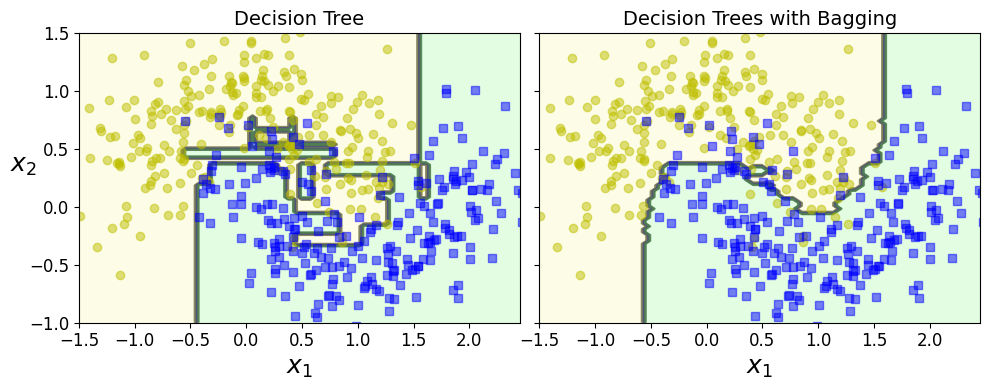

In [33]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

In [35]:
# Bootstrapping introduces a bit more diversity in the subsets that each predictor is
# trained on, so bagging ends up with a slightly higher bias than pasting; 
# but the extra diversity also means that the predictors end up being less correlated, 
# so the ensemble’s variance is reduced.

# Overall, bagging often results in better models, which explains 
# why it is generally preferred. However, if you have spare time and CPU power, 
# you can use cross-validation to evaluate both bagging and pasting 
# and select the one that works best.

In [36]:
# Out-of-Bag Evaluation

In [37]:
# By default a BaggingClassifier samples m training instances with replacement 
# (bootstrap=True), where m is the size of the training set.

# This means that only about 63% of the training instances are sampled on
# average for each predictor.6 The remaining 37% of the training instances that 
# are not sampled are called out-of-bag (oob) instances.

# In Scikit-Learn, you can set oob_score=True when creating a BaggingClassifier 
# to request an automatic oob evaluation after training. 
# The following code demonstrates this. 
# The resulting evaluation score is available through the oob_score_ variable:

In [38]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [39]:
# According to this oob evaluation, this BaggingClassifier is likely to achieve 
# about 90.1% accuracy on the test set. Let’s verify this:

In [40]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

In [41]:
# We get 91.2% accuracy on the test set—close enough!

# The oob decision function for each training instance is also 
# available through the oob_decision_function_ variable.

# In this case (since the base estimator has a pre dict_proba() method), 
# the decision function returns the class probabilities for each training instance.

In [42]:
bag_clf.oob_decision_function_

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.09497207, 0.90502793],
       [0.31147541, 0.68852459],
       [0.01754386, 0.98245614],
       [0.97109827, 0.02890173],
       [0.97765363, 0.02234637],
       [0.74404762, 0.25595238],
       [0.        , 1.        ],
       [0.7173913 , 0.2826087 ],
       [0.85026738, 0.14973262],
       [0.97222222, 0.02777778],
       [0.0625    , 0.9375    ],
       [0.        , 1.        ],
       [0.97837838, 0.02162162],
       [0.94642857, 0.05357143],
       [1.        , 0.        ],
       [0.01704545, 0.98295455],
       [0.39473684, 0.60526316],
       [0.88700565, 0.11299435],
       [1.        , 0.        ],
       [0.97790055, 0.02209945],
       [0.        , 1.        ],
       [0.99428571, 0.00571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.62569832, 0.37430168],
       [0.

In [43]:
# Random Patches and Random Subspaces

In [44]:
# The BaggingClassifier class supports sampling the features as well. 
# Sampling is controlled by two hyperparameters: max_features and bootstrap_features. 
# They work the same way as max_samples and bootstrap, 
# but for feature sampling instead of instance sampling.

# This technique is particularly useful when you are dealing with high-dimensional
# inputs (such as images). Sampling both training instances and 
# features is called the Random Patches method.

# Keeping all training instances (by setting bootstrap=False and max_samples=1.0) 
# but sampling features (by setting bootstrap_features to True and/or max_features to 
# a value smaller than 1.0) is called the Random Subspaces method.

In [45]:
# Random Forests

In [46]:
# A Random Forest9 is an ensemble of Decision Trees, generally
# trained via the bagging method (or sometimes pasting), 
# typically with max_samples set to the size of the training set.

# Instead of building a BaggingClassifier and passing it a DecisionTreeClassifier, 
# you can instead use the RandomForestClassifier class, 
# which is more convenient and optimized for Decision Trees10 
# (similarly, there is a RandomForestRegressor class for regression tasks).

In [47]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [48]:
# With a few exceptions, a RandomForestClassifier has all the hyperparameters
# of aDecisionTreeClassifier (to control how trees are grown), 
# plus all the hyperparameters of a BaggingClassifier to control the ensemble itself.

# The Random Forest algorithm introduces extra randomness when growing trees;
# instead of searching for the very best feature when splitting a node, 
# it searches for the best feature among a random subset of features.

# The algorithm results in greater tree diversity, 
# which (again) trades a higher bias for a lower variance,
# generally yielding an overall better model. The following BaggingClassifier
# is roughly equivalent to the previous RandomForestClassifier:

In [49]:
bag_clf = BaggingClassifier(
DecisionTreeClassifier(splitter="random", max_leaf_nodes=16),
n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

In [50]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [51]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # very similar predictions


np.float64(0.976)

In [53]:
# Feature Importance

In [54]:
# Yet another great quality of Random Forests is that they make it 
# easy to measure the relative importance of each feature. 
# Scikit-Learn measures a feature’s importance by looking at how much 
# the tree nodes that use that feature reduce impurity on average (across all trees in the forest).

# Scikit-Learn computes this score automatically for each feature after training, 
# then it scales the results so that the sum of all importances is equal to 1. \
# You can access the result using the feature_importances_ variable.

In [55]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


In [56]:
# Similarly, if you train a Random Forest classifier on the MNIST dataset 
# (introduced in Chapter 3) and plot each pixel’s importance, 
# you get the image represented in Figure 7-6.

In [57]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [58]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [60]:

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


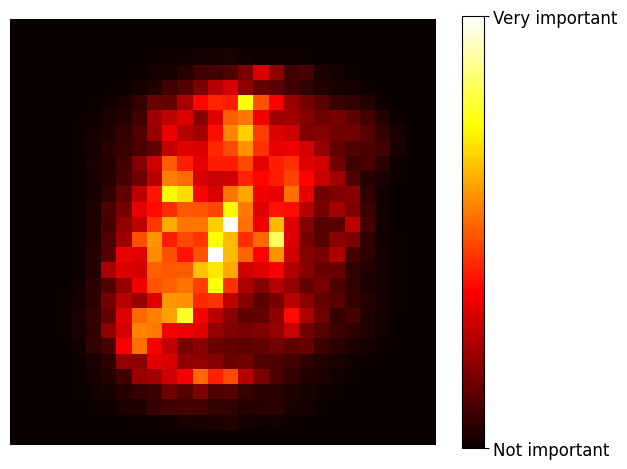

In [61]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

In [62]:
# Random Forests are very handy to get a quick understanding of what features
# actually matter, in particular if you need to perform feature selection.

In [63]:
# Boosting

In [64]:
# Boosting (originally called hypothesis boosting) refers to any 
# Ensemble method that can combine several weak learners into a strong learner.

# The general idea of most boosting methods is to train predictors sequentially, 
# each trying to correct its predecessor.

# There are many boosting methods available, but by far the most popular are
# AdaBoost13 (short for Adaptive Boosting) and Gradient Boosting. 
# Let’s start with AdaBoost.

In [65]:
# AdaBoost

In [66]:
# One way for a new predictor to correct its predecessor is to pay a bit more 
# attention to the training instances that the predecessor underfitted.

# This results in new predictors focusing more and more on the hard cases. 
# This is the technique used by AdaBoost.

# For example, when training an AdaBoost classifier, 
# the algorithm first trains a base classifier (such as a Decision Tree) and 
# uses it to make predictions on the training set.

# The algorithm then increases the relative weight of 
# misclassified training instances. Then it trains a second classifier, 
# using the updated weights, and again makes predictions
# on the training set, updates the instance weights, and so on.

In [67]:
# Figure 7-8 shows the decision boundaries of five consecutive predictors 
# on the moons dataset.

# The first classifier gets many instances wrong, so their weights get boosted.
# The second classifier therefore does a better job on these instances, and so on.

# The plot on the right represents the same sequence of predictors, 
# except that the learning rate is halved.

Saving figure boosting_plot


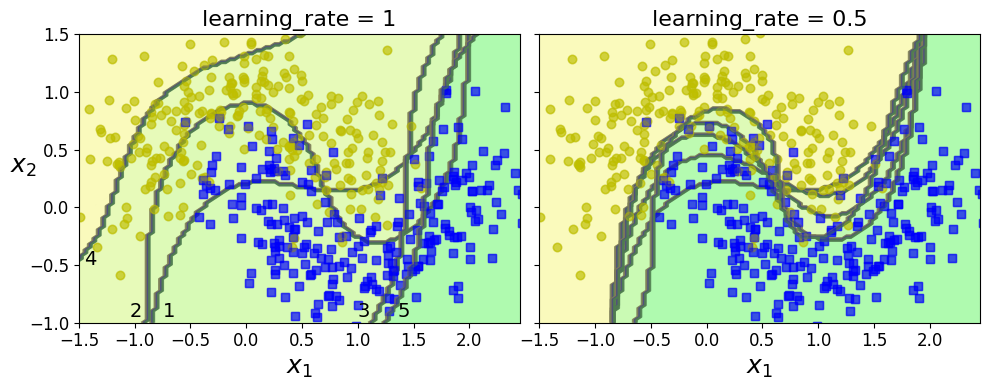

In [69]:
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

In [70]:
# There is one important drawback to this sequential learning technique:
# it cannot be parallelized (or only partially), since each predictor
# can only be trained after the previous predictor has been trained and evaluated. 
# As a result, it does not scale as well as bagging or pasting.

In [71]:
# The following code trains an AdaBoost classifier 
# based on 200 Decision Stumps using Scikit-Learn’s AdaBoostClassifier class 
# (as you might expect, there is also an Ada BoostRegressor class).

In [73]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Replace "SAMME.R" with "SAMME"
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME", learning_rate=0.5)

# This will now fit without an error
ada_clf.fit(X_train, y_train)

c:\Users\huysi\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


,estimator,DecisionTreeC...r(max_depth=1)
,n_estimators,200
,learning_rate,0.5
,algorithm,'SAMME'
,random_state,None
,criterion,'gini'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


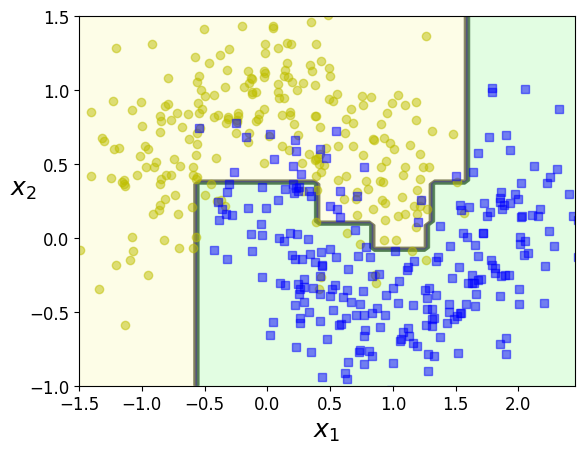

In [74]:
plot_decision_boundary(ada_clf, X, y)

In [75]:
# If your AdaBoost ensemble is overfitting the training set, 
# you can try reducing the number of estimators or 
# more strongly regularizing the base estimator.

In [76]:
# Gradient Boosting

In [77]:
# Another very popular boosting algorithm is Gradient Boosting. 
# Just like AdaBoost, Gradient Boosting works by sequentially adding predictors 
# to an ensemble, each one correcting its predecessor.

# However, instead of tweaking the instance weights at every 
# iteration like AdaBoost does, this method tries to fit the new predictor 
# to the residual errors made by the previous predictor.

In [78]:
# Let’s go through a simple regression example, using Decision Trees as the 
# base predictors (of course, Gradient Boosting also works great with regression tasks). 
# This is called Gradient Tree Boosting, 
# or Gradient Boosted Regression Trees (GBRT). 
# First, let’s fit a DecisionTreeRegressor to the training set 
# (for example, a noisy quadratic training set):

In [88]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [96]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

,criterion,'squared_error'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [90]:
# Next, we’ll train a second DecisionTreeRegressor on the 
# residual errors made by the first predictor:

In [97]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

,criterion,'squared_error'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [98]:
# Then we train a third regressor on the residual errors made 
# by the second predictor:

In [102]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

,criterion,'squared_error'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [100]:
# Now we have an ensemble containing three trees. 
# It can make predictions on a new instance simply by 
# adding up the predictions of all the trees:

In [101]:
X_new = np.array([[0.8]])

In [104]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [105]:
y_pred

array([0.75026781])

In [106]:
# Figure 7-9 represents the predictions of these three trees in the left column, 
# and the ensemble’s predictions in the right column.

# In the first row, the ensemble has just one tree, 
# so its predictions are exactly the same as the first tree’s predictions. 
# In the second row, a new tree is trained on the residual errors of the first tree. 

# On the right you can see that the ensemble’s predictions are equal 
# to the sum of the predictions of the first two trees.

# Similarly, in the third row another tree is trained on 
# the residual errors of the second tree.

In [107]:
# A simpler way to train GBRT ensembles is to use 
# Scikit-Learn’s GradientBoostingRe gressor class. 
# Much like the RandomForestRegressor class, it has hyperparameters to
# control the growth of Decision Trees (e.g., max_depth, min_samples_leaf), 
# as well as hyperparameters to control the ensemble training, 
# such as the number of trees (n_estimators).

In [108]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

,loss,'squared_error'
,learning_rate,1.0
,n_estimators,3
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,2
,min_impurity_decrease,0.0
,init,None


In [109]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure gradient_boosting_plot


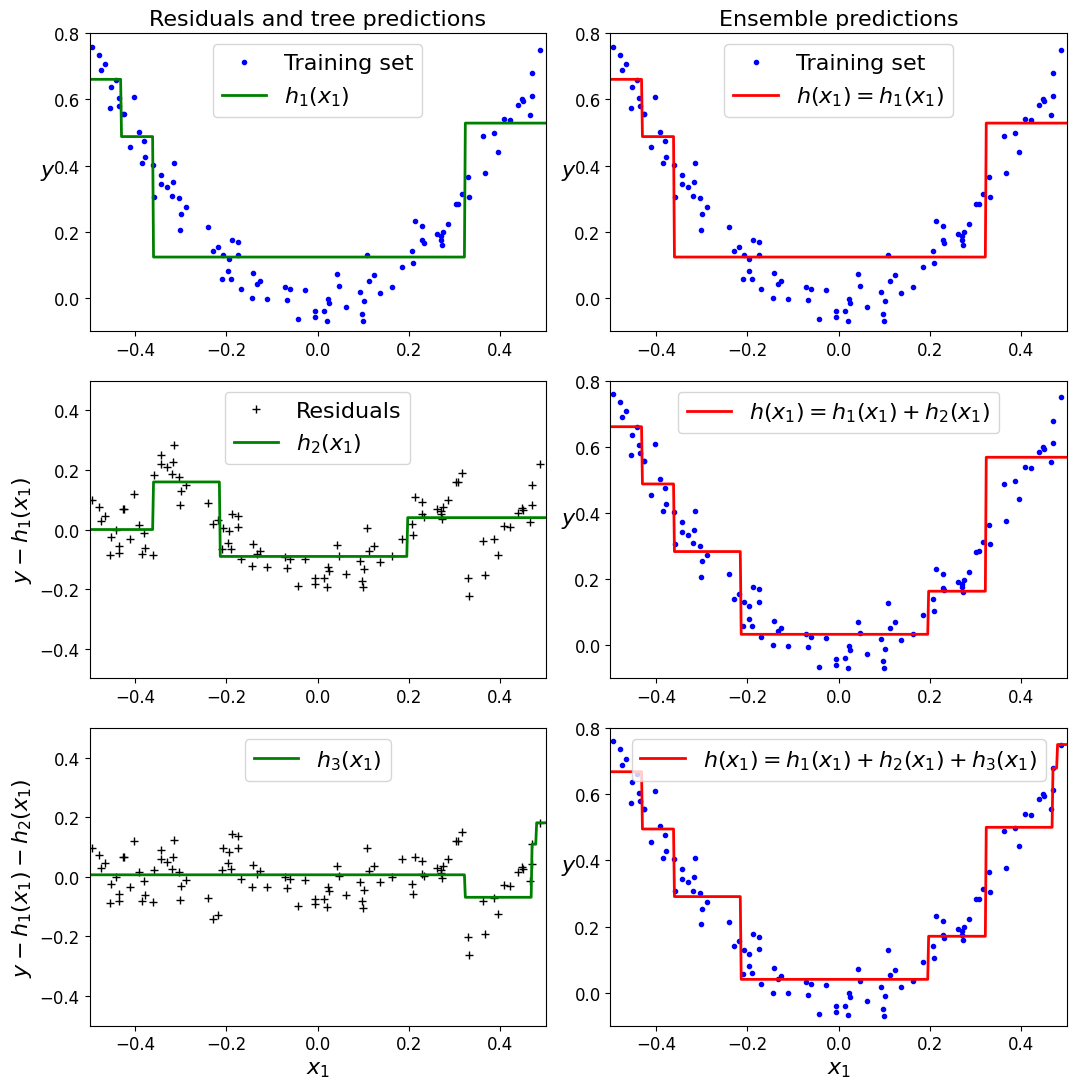

In [110]:
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

In [111]:
# Figure 7-9. In this depiction of Gradient Boosting, 
# the first predictor (top left) is trained normally, 
# then each consecutive predictor (middle left and lower left) 
# is trained on the previous predictor’s residuals; 
# the right column shows the resulting ensemble’s predictions.

In [112]:
# The learning_rate hyperparameter scales the contribution of each tree. 
# If you set it to a low value, such as 0.1, 
# you will need more trees in the ensemble to fit the training set, 
# but the predictions will usually generalize better.

# This is a regularization technique called shrinkage. 
# Figure 7-10 shows two GBRT ensembles trained with a low learning rate: 
# the one on the left does not have enough trees to fit the training set, 
# while the one on the right has too many trees and overfits the training set.

In [114]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

,loss,'squared_error'
,learning_rate,0.1
,n_estimators,200
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,2
,min_impurity_decrease,0.0
,init,None


Saving figure gbrt_learning_rate_plot


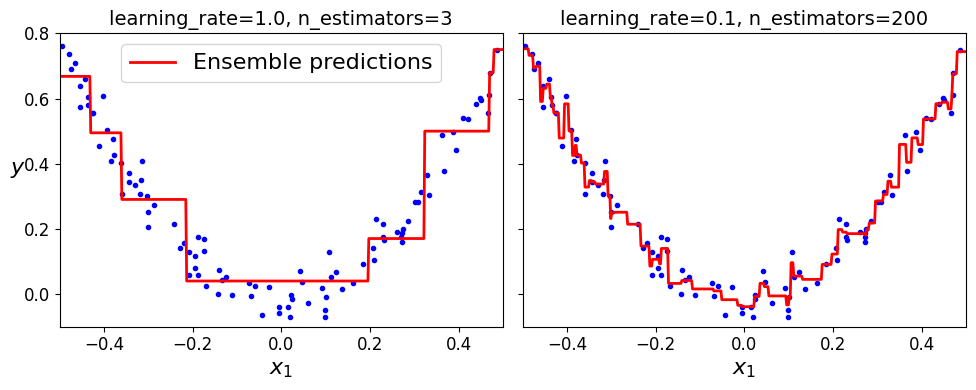

In [115]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

In [117]:
# In order to find the optimal number of trees, 
# you can use early stopping (see Chapter 4). 
# A simple way to implement this is to use the staged_predict() method: 
# it returns an iterator over the predictions made by the ensemble 
# at each stage of training (with one tree, two trees, etc.).

# The following code trains a GBRT ensemble with 120 trees, 
# then measures the validation error at each stage of training to 
# find the optimal number of trees, and finally trains another GBRT ensemble 
# using the optimal number of trees:

In [119]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
        for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

,loss,'squared_error'
,learning_rate,0.1
,n_estimators,np.int64(36)
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,2
,min_impurity_decrease,0.0
,init,None


In [120]:
# The validation errors are represented on the left of Figure 7-11, 
# and the best model’s predictions are represented on the right.

In [121]:
min_error = np.min(errors)


Saving figure early_stopping_gbrt_plot


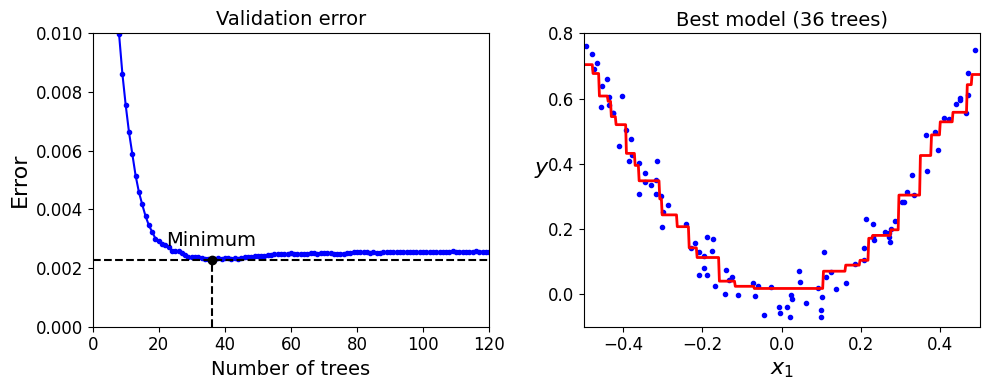

In [122]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

In [124]:
# It is also possible to implement early stopping by actually 
# stopping training early (instead of training a large number of trees first 
# and then looking back to find the optimal number).

# You can do so by setting warm_start=True, which makes Scikit-Learn 
# keep existing trees when the fit() method is called, 
# allowing incremental training.

# The following code stops training when the validation error does not
# improve for five iterations in a row:

In [ ]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break # early stopping

In [137]:
print(gbrt.n_estimators)

41


In [138]:

print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002289717131455434


In [126]:
# The GradientBoostingRegressor class also supports a subsample hyperparameter,
# which specifies the fraction of training instances to 
# be used for training each tree.

# For example, if subsample=0.25, then each tree is trained on 25% of 
# the training instances, selected randomly. As you can probably guess by now, 
# this technique trades a higher bias for a lower variance. 
# It also speeds up training considerably. 
# This is called Stochastic Gradient Boosting.

In [127]:
# It is possible to use Gradient Boosting with other cost functions.
# This is controlled by the loss hyperparameter.

In [128]:
# It is worth noting that an optimized implementation of Gradient Boosting is 
# available in the popular Python library XGBoost, 
# which stands for Extreme Gradient Boosting.

In [139]:
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None



In [140]:

if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # Not shown
    print("Validation MSE:", val_error)     

Validation MSE: 0.003953195851195014


In [131]:
# XGBoost also offers several nice features, 
# such as automatically taking care of early stopping:

In [142]:
import xgboost

# Set early_stopping_rounds when creating the model instance
xgb_reg = xgboost.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=1000, # Set a high number, since early stopping will find the optimal number
    early_stopping_rounds=2
)

# Call fit() without the early_stopping_rounds parameter
xgb_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)])


[0]	validation_0-rmse:0.13963
[1]	validation_0-rmse:0.10383
[2]	validation_0-rmse:0.07951
[3]	validation_0-rmse:0.06743
[4]	validation_0-rmse:0.06058
[5]	validation_0-rmse:0.05778
[6]	validation_0-rmse:0.05497
[7]	validation_0-rmse:0.05541


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,2
,enable_categorical,False
,eval_metric,None


In [143]:
%timeit xgboost.XGBRegressor().fit(X_train, y_train) if xgboost is not None else None


29.3 ms ± 6.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [144]:
%timeit GradientBoostingRegressor().fit(X_train, y_train)


34.9 ms ± 2.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
